# Novel predictions

Here, we ran our method on our all corpus of PubMed abstracts up to December 2020. We considered all clinical trials up to 2020 and also clinical trials that have been verified in 2021. We then constructed the positive training set using all PK-cancer pairs from clinical trials of phase IV. The negative training set contains randomly generated pairs of PKs and cancers where there was no evidence of treating the cancers by inhibiting the PK in the clinical trials data. Similar to the historical prediction analysis, we chose the size of the negative training set to be 10 times the size of the positive training set. The prediction set includes all possible PK-cancer pairs except those where there was evidence of treating the PKs in any of phase I, II, III or IV clinical trials that have been published so far. The prediction set also contains PK-cancer pairs for PKs that have not been targeted yet. 

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, precision_recall_curve,precision_score, recall_score
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import pickle5 as pickle
sys.path.insert(0, os.path.abspath('..'))
from kcet import KcetDatasetGenerator, KcetRandomForest

## Obtaining the input data
The concept vectors are available from a zenodo repository: https://zenodo.org/record/5329035 Download the five files to a local directory and enter the path of this directory in the following input dialog

- embedding_SG_dim100_upto2010.npy
- embedding_SG_dim100_upto2020.npy
- words_SG_upto2010.txt
- words_SG_upto2020.txt
- clinical_trials_by_phase.tsv


To run this notebook, download all of these files to the same directory and enter the path to the directory after running the ``input()`` command.

In [2]:
download_dir = input()

 /home/peter/data/pubmed2vec


In [3]:
ctfile = os.path.join(download_dir, "clinical_trials_by_phase.tsv")
embeddings = os.path.join(download_dir, "embedding_SG_dim100_upto2020.npy")
words =  os.path.join(download_dir, "words_SG_upto2020.txt")
if not os.path.isfile(ctfile):
    raise FileNotFoundError("Could not find clinical trials file at %s" % ctfile)
if not os.path.isfile(embeddings):
    raise FileNotFoundError("Could not find 2020 embeddings file at %s" % embeddings)
if not os.path.isfile(words):
    raise FileNotFoundError("Could not find 2020 words file at %s" % words)  

# Training
We fix the year to the last year for which we extracted data (2020) and get all available phase 4 clinical trials for test and training on this dataset.
For the predicton set, we consider all possible links between  protein kinases and the cancers except the positive dataset calculated up to the current year.

In [4]:
target_year = 2020
dsGen = KcetDatasetGenerator(clinical_trials=ctfile, embeddings=embeddings, words=words)

In [5]:
dsGen.get_summary()

,Item,Value
0,protein kinases in NCBI gene dataset,522
1,MeSH Ids for cancer concepts,698
2,Clinical trials included in this study,7909
3,Phase 1 trials included in this analysis,3676
4,Phase 2 trials included in this analysis,4071
5,Phase 3 trials included in this analysis,135
6,Phase 4 trials included in this analysis,27
7,word/concept embeddings,293274


## Load word/concept embeddings

Note that the embeddings that are shown here include embeddings for all words/concepts in the PubMed dataset. For classification, we extract the subset of vectors that represent cancers and protein kinases (in the form of difference vectors, see below).

In [6]:
embeddings = dsGen.get_embeddings()
embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,2.892186,-4.601290,1.886768,3.363972,5.323241,2.037415,-4.547163,2.887746,0.078090,-6.857232,...,-2.348537,4.792399,3.246019,-3.045483,-4.771703,6.965374,-1.852824,0.788342,0.692204,8.816134
patient,3.030980,-4.654769,1.988458,3.286587,4.494266,4.335152,-3.879949,1.414752,0.948940,-4.057512,...,-1.655231,5.274243,5.277645,-1.659015,-4.128818,5.872729,-3.746760,1.387476,-0.132648,8.704845
meshd009369,3.125736,-5.037050,1.834232,3.044192,4.652200,3.345147,-2.471191,2.407151,0.459735,-5.215952,...,-1.343417,3.949077,5.909581,-3.753628,-5.255637,6.504014,-3.489765,1.265763,0.166798,9.207653
0,3.207781,-5.854365,2.169951,2.806666,3.704714,4.489932,-3.641227,2.849144,1.368201,-5.305769,...,-1.802601,4.349891,5.042999,-1.330444,-3.057492,6.769782,-4.191097,0.704711,0.271818,7.927824
study,3.093263,-3.081187,1.896351,3.586287,3.835986,3.025896,-3.602392,3.394049,0.388296,-4.770427,...,-1.487065,4.371748,4.851753,-3.033936,-4.145646,6.956510,-3.810457,0.859616,0.380740,8.665388
1,3.018538,-3.605780,2.182852,2.932359,3.923348,3.637897,-3.416155,2.005841,1.166031,-4.748892,...,-1.323698,4.395097,3.887243,-2.264642,-3.399752,6.595658,-3.176540,0.921026,-0.217930,8.002831
use,3.175536,-3.883943,2.084331,2.947140,4.180398,4.311874,-4.265388,2.095730,0.419745,-5.925326,...,-2.399938,4.892245,3.914755,-2.971247,-3.429977,5.416573,-4.076387,1.561274,0.717877,9.099863
treatment,3.261678,-3.350174,2.096332,3.783587,2.961497,3.400727,-3.728835,2.151285,0.226021,-4.506880,...,-1.157140,5.029034,5.780355,-3.293498,-3.552152,6.936460,-2.832863,0.838427,0.488065,8.168900
expression,3.106493,-3.050670,2.355245,3.814924,3.019568,3.326808,-3.774094,1.754938,0.224645,-5.438403,...,-2.060218,3.289309,3.884068,-1.966218,-5.751972,6.421821,-3.770080,1.560570,0.603475,9.072812
2,3.148104,-3.438452,2.135574,3.561711,3.710183,3.536714,-3.620656,2.181449,1.015460,-4.454979,...,-1.291311,4.609010,4.067603,-2.394429,-3.716997,6.879407,-3.375000,0.777139,-0.384705,8.311201


## Extract positive and negative training examples (difference vectors)

The variables ``positive_train_df``, ``negative_train_df``, and ``prediction_df`` are  pandas dataframes that contain difference vectors formed by substracting the word vectors for the protein kinases (in the column ``gene.id``)
from the corresponding vectors for the cancer (in the column ``mesh_id``).

In [7]:
positive_training_df, negative_training_df, prediction_df = dsGen.get_data_for_novel_prediction(target_year=target_year)

364000/364356 links extracted (99.90%)

# Optionally store the above vectors to file
The previous step takes roughly 2 hours on a typical commodity computer and thus if desired, store the vectors to file with the following cell. This allows the
previous step to be skipped once the files are stored.

In [8]:
positive_pickle_path = "pos_train_vectors.pkl"
negative_pickle_path = "neg_train_vectors.pkl"
pred_pickle_path = "pred_vectors.pkl"
if os.path.isfile(positive_pickle_path) and os.path.isfile(negative_pickle_path) and os.path.isfile(pred_pickle_path):
    print("loading vectors from file")
    with open(positive_pickle_path, "rb") as f:
         positive_training_df = pickle.load(f)
    with open(negative_pickle_path, "rb") as f:
        negative_training_df = pickle.load(f)
    with open(pred_pickle_path, "rb") as f:
        prediction_df = pickle.load(f)
else:
    print("storing vectors to file")
    positive_training_df.to_pickle(positive_pickle_path)
    negative_training_df.to_pickle(negative_pickle_path)
    prediction_df.to_pickle(pred_pickle_path)

loading vectors from file


In [11]:
n_positive_examples = positive_training_df.shape[0]
n_negative_examples = negative_training_df.shape[0]
n_examples_for_prediction = prediction_df.shape[0]
print("positive training examples: %d; negative examples: %d; examples for prediction: %d" % (n_positive_examples, n_negative_examples, n_examples_for_prediction))

positive training examples: 557; negative examples: 5570; examples for prediction: 325494


In [12]:
prediction_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene23552-meshd000008,0.708197,1.290104,0.561938,-0.099391,1.151502,-0.743111,-1.097506,-1.140788,-0.228039,-0.000998,...,-0.584290,0.115289,0.182056,-1.740004,1.747286,1.337672,-1.003394,-0.067877,0.314209,-0.146105
ncbigene23552-meshd000069293,1.422597,0.577610,0.680395,0.114170,1.359240,-0.015148,-0.157970,-0.657875,0.065483,0.014552,...,-0.376531,0.509528,-0.034168,-1.419383,1.380829,1.882058,-0.301778,-0.201751,0.157687,0.624365
ncbigene23552-meshd000069584,0.679305,-0.004023,0.523511,-0.450354,0.490123,-0.402770,-1.688186,-2.444986,-0.504033,-0.748134,...,0.045433,-0.717899,0.331410,-0.820566,1.714909,0.100310,-0.417283,0.213280,1.174330,0.138305
ncbigene23552-meshd000070779,1.151146,0.914599,0.629768,0.571509,0.826595,-0.892867,-0.926174,-0.515938,0.383801,-0.677248,...,-0.393525,-0.404764,0.297285,-0.904665,1.380163,1.050284,0.172301,-0.037946,0.460384,-0.532447
ncbigene23552-meshd000071380,1.654519,0.218517,1.167848,0.482340,1.093505,0.097858,-1.306451,-0.876615,0.321109,-0.974852,...,-0.926187,0.802710,1.364528,-1.569548,0.882294,1.580470,-1.177857,0.321215,0.507300,0.833965


## Visualize positive and negative examples

We show both PCA and t-SNE plots to compare the distributions of the positive (red) and negative (blue) examples.

In [10]:
X_train = positive_training_df.append(negative_training_df)
print("[INFO] positive (n=%d) and negative (n=%d) examples" % 
      (len(positive_training_df), len(negative_training_df)))

[INFO] positive (n=557) and negative (n=5570) examples


In [11]:
# vector with colors for the data points -- red for positive, blue for negative
cvec = ["red"] * len(positive_training_df) + ["blue"]* len(negative_training_df)

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.7061124  0.03181363 0.02741456]


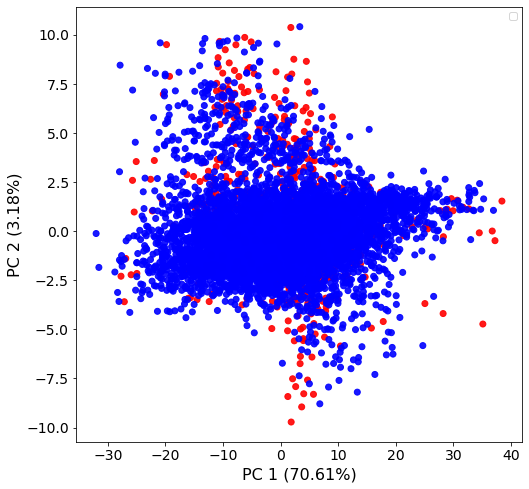

In [13]:
plt.figure(figsize=(8,8))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(pca_result[:,0], pca_result[:,1], c=cvec, alpha=0.9)
plt.legend()
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100), fontsize=16);
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100), fontsize=16);

## T-Distributed Stochastic Neighbouring Entities (t-SNE) Plot

In [14]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6127 samples in 0.002s...
[t-SNE] Computed neighbors for 6127 samples in 0.946s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6127
[t-SNE] Computed conditional probabilities for sample 2000 / 6127
[t-SNE] Computed conditional probabilities for sample 3000 / 6127
[t-SNE] Computed conditional probabilities for sample 4000 / 6127
[t-SNE] Computed conditional probabilities for sample 5000 / 6127
[t-SNE] Computed conditional probabilities for sample 6000 / 6127
[t-SNE] Computed conditional probabilities for sample 6127 / 6127
[t-SNE] Mean sigma: 2.473580
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.630699
[t-SNE] KL divergence after 300 iterations: 2.418274
t-SNE done! Time elapsed: 4.302544355392456 seconds


Text(0, 0.5, 'tsne-2d-two')

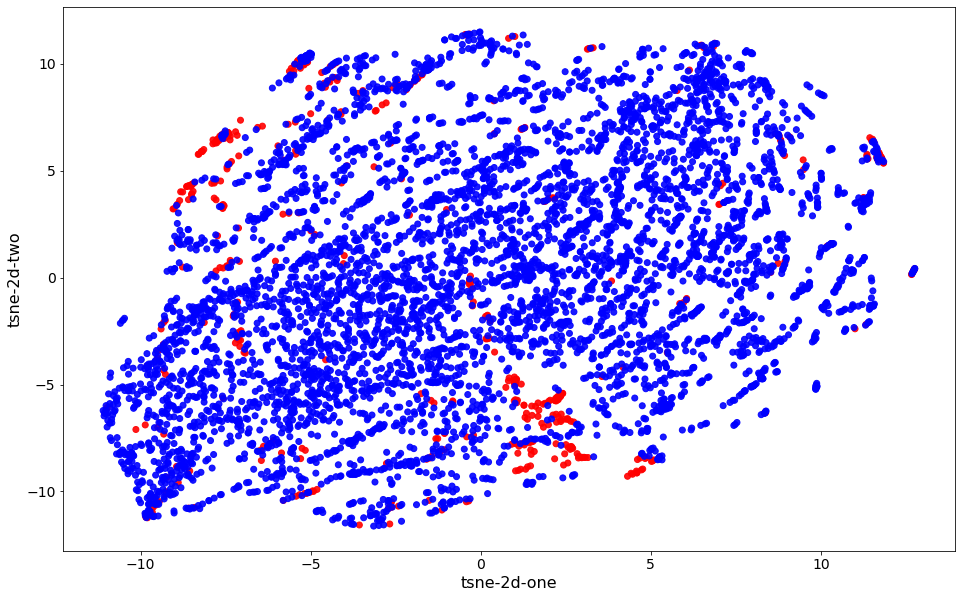

In [15]:
plt.figure(figsize=(16,10))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cvec, alpha=0.9)
plt.xlabel('tsne-2d-one', fontsize=16)
plt.ylabel('tsne-2d-two', fontsize=16) 

# Random forest
Here, we train a random forest model using all available training data

In [16]:
label_1 = np.ones(positive_training_df.shape[0])
label_0 = np.zeros(negative_training_df.shape[0])
y_train = np.concatenate((label_1,label_0))
print("Total training labels: %d" % len(y_train))

Total training labels: 6127


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

n_estimators = [100, 200, 300, 400, 500]
max_features = ['auto', 'sqrt']
max_depth = [10, 20, 30, 40, 50, None]
min_samples_split = [2, 3, 5, 7, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1, cv = 10, random_state=42)

rf_random.fit(X_train,y_train)

best_model = rf_random.best_estimator_

In [18]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

## Classification results
The ``KcetParser`` class has methods that take the labels of the difference vectors used for classification (e.g.,  ``ncbigene5599-meshd000074723``) and show the corresponding gene symbols and MeSH labels (neoplasms) as well as the Random Forest predictions.

The ``deleteEmbeddings`` argument determines whether we only return the
three columns ``gene_symbol1``, ``cancer``, and ``probability``.

In [19]:
y_pred = best_model.predict(prediction_df)
yproba = best_model.predict_proba(prediction_df)[::,1]

from kcet import KcetParser
kcetParser = KcetParser()
predictions = kcetParser.decode_predictions(vectors=prediction_df, probabilities=yproba, deleteEmbeddings=True)
predictions.head(n=20)

,gene_symbol,cancer,probability
ncbigene2066-meshd009362,ERBB4,Neoplasm Metastasis,1.000000
ncbigene3791-meshd006528,KDR,"Carcinoma, Hepatocellular",1.000000
ncbigene5979-meshd006528,RET,"Carcinoma, Hepatocellular",1.000000
ncbigene6098-meshd009362,ROS1,Neoplasm Metastasis,1.000000
ncbigene3815-meshd008175,KIT,Lung Neoplasms,1.000000
ncbigene3815-meshd001943,KIT,Breast Neoplasms,1.000000
ncbigene2322-meshd009362,FLT3,Neoplasm Metastasis,1.000000
ncbigene3815-meshd000070779,KIT,Giant Cell Tumor of Tendon Sheath,0.995132
ncbigene3815-meshd005870,KIT,Giant Cell Tumors,0.990188
ncbigene5156-meshd008175,PDGFRA,Lung Neoplasms,0.985000


In [20]:
print("Total number of predictions:", len(predictions))

Total number of predictions: 325494


## Optimal Threshold
To choose a threshold for calling a prediction 'positive', we use all the available training data to train a random forest and then "a posteriori" select the threshold that maximizes the g-means computed on the same training data.

In [21]:
y_pred_train = best_model.predict(X_train)
y_prob_train = best_model.predict_proba(X_train)[::,1]
fpr, tpr, thresholds = roc_curve(y_train, y_prob_train)

In [22]:
from numpy import sqrt,argmax
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
opt_thres = thresholds[ix]
print('Best threshold=%f' % opt_thres)

Best threshold=0.491062


In [23]:
positive_preds = prediction_df[prediction_df['probability'] >= opt_thres]
negative_preds = prediction_df[prediction_df['probability'] < opt_thres]

In [24]:
n_positive = len(positive_preds)
n_examples_for_prediction = len(prediction_df)
percentage_pos = 100*n_positive / n_examples_for_prediction
print("{}/{} ({:.2f}%) examples had an above-threshold probability".format(n_positive, n_examples_for_prediction, percentage_pos))

2979/325494 (0.92%) examples had an above-threshold probability


# Save novel predictions to file.
The following command saves the positive predictions to a file called ``predictions_above_threshold.tsv`` and also saves all predictions to ``predicions_all.tsv``. The file ``predictions_above_threshold.tsv`` was also made available as Supplemental Material File 3.

In [27]:
def decode_positive_predictions(pos_pred_df: pd.DataFrame) -> pd.DataFrame:
    data = []
    for i, row in pos_pred_df.iterrows():
        gene_symbol = row['gene_symbol']
        cancer = row['cancer']
        probability = row['probability']
        data.append({'gene_symbol': gene_symbol, 'cancer':cancer, 'probability':probability})
    data.sort(key=lambda x: float(x['probability']), reverse=True)
    return pd.DataFrame(data)


In [28]:
df = decode_positive_predictions(positive_preds)
df.head()

,gene_symbol,cancer,probability
0,FLT3,Neoplasm Metastasis,1.0
1,KDR,"Carcinoma, Hepatocellular",1.0
2,KIT,Breast Neoplasms,1.0
3,KIT,Lung Neoplasms,1.0
4,ROS1,Neoplasm Metastasis,1.0


In [29]:
df.to_csv("predictions_above_threshold.tsv",index=False,sep="\t")
df = decode_positive_predictions(prediction_df)
df.to_csv("predicions_all.tsv",index=False,sep="\t")

## Visualizing positive and negative examples
Here, we plot the distributions of the probabiliies of the positive and negative training samples as calculated by the random forest.

In [30]:
n_pos_train= len(positive_training_df)
n_neg_train = len(negative_training_df)
pos_train_probs = y_prob_train[:n_pos_train]
neg_train_probs = y_prob_train[n_pos_train:]
print("[INFO] Got %d positive and %d negative predictions" % (len(pos_train_probs), len(neg_train_probs)))

[INFO] Got 557 positive and 5570 negative predictions


In [31]:
posnp = np.array(pos_train_probs)
pos_train = pd.Series(posnp, name="Prediction score of positive training")
negnp = np.array(neg_train_probs)
neg_train = pd.Series(negnp, name="Prediction score of negative training")

In [32]:
probability = predictions['probability'].tolist()
prediction_scores = np.array(probability)
prediction = pd.Series(prediction_scores, name="Prediction score")

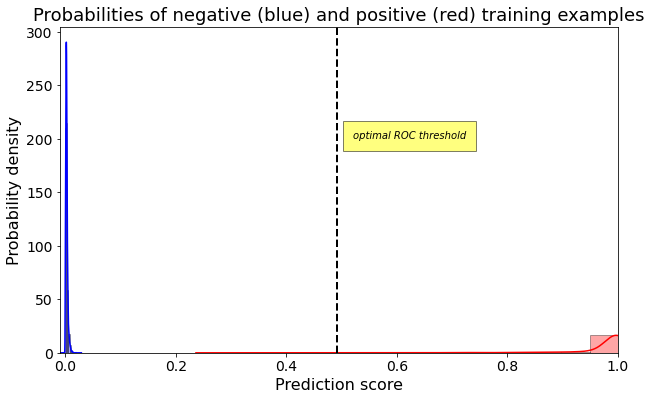

In [33]:
fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(111)

pos_train.plot.kde(ax=ax1, legend=False,color ="red")
pos_train.plot.hist(density = True, ax=ax1, color="red", edgecolor="black", alpha = 0.35)
neg_train.plot.kde(ax=ax1, legend=False,color ="blue")
neg_train.plot.hist(density=True, ax=ax1, color="blue", edgecolor="black", alpha = 0.35)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([-0.01, 1.0])
plt.axvline(x=opt_thres, linewidth=2, color='k', linestyle='--')
ax1.text(opt_thres+0.03, 200, 'optimal ROC threshold', style='italic',
        bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 10})
plt.title("Probabilities of negative (blue) and positive (red) training examples", fontsize=18)
ax1.set_xlabel("Prediction score", fontsize=16);
ax1.set_ylabel('Probability density', fontsize=16);
fig.savefig("neg-and-pos-examples.pdf")

# Distribution of predictions

The vast majority of the protein-kinase-cancer pairs receive a low prediction score.

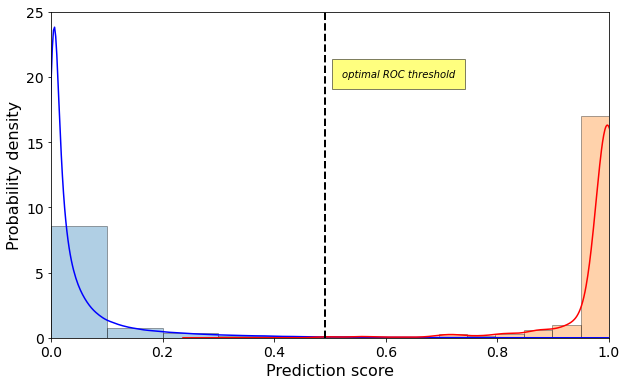

In [34]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

prediction.plot.kde(ax=ax, legend=False,color ="blue")
prediction.plot.hist(density=True, ax=ax, edgecolor="black", alpha = 0.35)

pos_train.plot.kde(ax=ax, legend=False,color ="red")
pos_train.plot.hist( density = True, ax=ax, edgecolor="black", alpha = 0.35)
plt.axvline(x=opt_thres, linewidth=2, color='k', linestyle='--')
ax.text(opt_thres+0.03, 20, 'optimal ROC threshold', style='italic',
        bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 10})
plt.xlim([0.0, 1.0])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xlabel("Prediction score", fontsize=16);
ax.set_ylabel('Probability density', fontsize=16);
fig.savefig("pos-vs-new-predictions.pdf")

Here we show the predictions for negative training, positive training, and de novo predictions (i.e., everything else)

In [37]:
data = []
data.append({'level': 'min', 'pos': np.min(posnp), 'neg': np.min(negnp), 'pred': np.min(prediction_scores)})
for i in [1, 5, 10, 20, 80, 90, 95, 99, 99.5, 99.9, 99.99]:
    data.append({'level': 'percentile: %.2f'%i, 'pos': np.percentile(posnp, i), 'neg': np.percentile(negnp, i), 'pred': np.percentile(prediction_scores, i)})
data.append({'level': 'max', 'pos': np.max(posnp), 'neg': np.max(negnp), 'pred': np.max(prediction_scores)})
df = pd.DataFrame(data)
df.head(20)

,level,pos,neg,pred
0,min,0.578544,0.000000,0.000000
1,percentile: 1.00,0.663466,0.000032,0.000596
2,percentile: 5.00,0.857218,0.000397,0.000963
3,percentile: 10.00,0.932957,0.000641,0.001418
4,percentile: 20.00,0.980616,0.000982,0.002611
5,percentile: 80.00,1.000000,0.003470,0.065900
6,percentile: 90.00,1.000000,0.004580,0.136775
7,percentile: 95.00,1.000000,0.005654,0.231416
8,percentile: 99.00,1.000000,0.008537,0.460348
9,percentile: 99.50,1.000000,0.010113,0.547185
